In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shutil as sh
import math
import time
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

FF 関数

In [2]:
def Rod(n,theta_in):
    nx,ny,nz=n
    theta_t=np.radians(theta_in)
    Rod=np.array([[np.cos(theta_t)+(nx**2)*(1-np.cos(theta_t)),nx*ny*(1-np.cos(theta_t))-nz*np.sin(theta_t),nx*nz*(1-np.cos(theta_t))+ny*np.sin(theta_t)],
                [nx*ny*(1-np.cos(theta_t))+nz*np.sin(theta_t),np.cos(theta_t)+(ny**2)*(1-np.cos(theta_t)),ny*nz*(1-np.cos(theta_t))-nx*np.sin(theta_t)],
                [nx*nz*(1-np.cos(theta_t))-ny*np.sin(theta_t),ny*nz*(1-np.cos(theta_t))+nx*np.sin(theta_t),np.cos(theta_t)+(nz**2)*(1-np.cos(theta_t))]])
    return Rod

def get_rot_axis_from_A2(A2):
    A2 = np.radians(A2)
    rot_axis1 = np.array([0.,0.,1.])
    rot_axis2 = np.array([
        -np.sin(A2),
        np.cos(A2),
        0.
    ])
    return rot_axis1, rot_axis2

def get_ab_from_params(R1,R2,heri):
    A_rad=np.radians(heri/2)
    a_=2*(R1*np.cos(A_rad)-R2*np.sin(A_rad))
    b_=2*(R2*np.cos(A_rad)+R1*np.sin(A_rad))
    return a_, b_ 

def getA1_from_R3t(a,R3t,glide):
    assert glide=='a'
    return np.rad2deg(np.arctan(R3t/(a/2)))

#分子を配列
# mono-Cn-BTBTを想定
def arrangeNN(atom_list,a,b,A1,A2,A3,phi1,phi2,glide):

    atom_list_i=[];atom_list_pa=[];atom_list_pb=[]
    atom_list_t1=[];atom_list_t2=[];atom_list_t3=[];atom_list_t4=[]

    #alkylの基準
    C0=np.array([atom_list[16][1],atom_list[16][2],atom_list[16][3]])
    C1=np.array([atom_list[23][1],atom_list[23][2],atom_list[23][3]])

    #phi1に関するalkylの軸
    n1=C1-C0
    n1/=np.linalg.norm(n1)

    #映進面によって回転角変える
    glide=180.0 if glide=='a' else 0.0

    #回転軸
    rot_axis_i1, rot_axis_i2 = get_rot_axis_from_A2(A2)
    rot_axis_t1, rot_axis_t2 = get_rot_axis_from_A2(-A2)

    #alkyl回転・分子1作成
    for ind,(x,y,z,R) in enumerate(atom_list):
        x1=x;y1=y;z1=z
        x2=x;y2=y;z2=z
        #alkylだけΦ回転　phi1=-phi2のとき映進
        if ind>=23:#alkyl?
            x1,y1,z1=np.matmul(Rod(n1,phi1),(np.array([x,y,z])-C0).T)
            x1,y1,z1=C0+np.array([x1,y1,z1])
            x2,y2,z2=np.matmul(Rod(n1,phi2),(np.array([x,y,z])-C0).T)
            x2,y2,z2=C0+np.array([x2,y2,z2])

        #heri/2回転 i,t作成
        x1,y1,z1=np.matmul(Rod(rot_axis_i1,A3 + A2),np.array([x1,y1,z1]).T)
        x1,y1,z1=np.matmul(Rod(rot_axis_i2,A1),np.array([x1,y1,z1]).T)
        
        x2,y2,z2=np.matmul(Rod(rot_axis_t1,-A3 - A2 +glide),np.array([x2,y2,z2]).T)
        x2,y2,z2=np.matmul(Rod(rot_axis_t2,A1),np.array([x2,y2,z2]).T)

        atom_list_i.append([x1,y1,z1,R])
        atom_list_p1.append([x1,b+y1,z1,R])
        atom_list_p2.append([x1,-b+y1,z1,R])
        atom_list_t1.append([a/2+x2,b/2+y2,z2,R]) 
        atom_list_t2.append([a/2+x2,-b/2+y2,z2,R])
        atom_list_t3.append([-a/2+x2,-b/2+y2,z2,R])
        atom_list_t4.append([-a/2+x2,b/2+y2,z2,R])

    xyz_NN=np.array(atom_list_p1+atom_list_p2+atom_list_t1+atom_list_t2+atom_list_t3+atom_list_t4)
    
    return xyz_NN

#mono-BTBT-Cnを想定。
def make_paraview(monomer_filename,a,b,heri,A1,A2,phi1,phi2,glide):
    base_dir = '/home/koyama/Working/interaction/paraview'
    df_mono=pd.read_csv(os.path.join(base_dir,monomer_filename))
    monomer=df_mono[['X','Y','Z','R']].values
    xyz_NN=arrangeNN(monomer,a,b,A1,A2,A3,phi1,phi2,glide)
    df_xyz = pd.DataFrame(data = xyz_NN, columns = ['X','Y','Y','R'])
    df_xyz.to_csv(os.path.join(os.path.dirname(in_csv_path),'A1={}'),index=False)


Test

In [221]:
make_paraview('BTBT.csv',)

out_dir = '/home/koyama/Working/interaction/mono-C4-BTBT/FF/'
monomer_path = os.path.join(out_dir,'monomer.csv')
R1=5.0
R2=0.6
heri=60.0
R3t = 0.6
A2 = 0
glide = 'a'
phi_list = np.arange(-180,181)

#計算準備
df=pd.DataFrame(columns=['R1','R2','A1','A2','A3','phi1','phi2','FF'])
df_mono=pd.read_csv(monomer_path) ###x,y,z,rad
monomer=df_mono[['atom','X','Y','Z','R','q','sig','eps']].values

#計算
a,b=get_ab_from_params(R1,R2,heri)
A1 = getA1_from_R3t(a,R3t,glide)
A3 = heri/2

for phi1 in tqdm(phi_list):
    phi2 = -phi1
    FF = calc_FF(monomer,a,b,A1,A2,A3,phi1,phi2,glide)
    data=pd.Series([R1,R2,A1,A2,A3,phi1,phi2,FF],index=df.columns)
    df=df.append(data,ignore_index=True)

#出力
type_='Y' if glide=='b' else 'Z'
df.to_csv(os.path.join(out_dir,'glide={}/FF_phi1phi2_{}-type_A1={}_A2={}.csv'.format(glide,type_,A1,A2)),index=False)







  0%|          | 0/361 [00:00<?, ?it/s]





  1%|          | 3/361 [00:00<00:12, 28.65it/s]





  2%|▏         | 7/361 [00:00<00:11, 31.22it/s]





  3%|▎         | 12/361 [00:00<00:10, 33.89it/s]





  5%|▍         | 17/361 [00:00<00:09, 36.31it/s]





  6%|▌         | 22/361 [00:00<00:08, 38.54it/s]





  7%|▋         | 27/361 [00:00<00:08, 39.53it/s]





  9%|▉         | 32/361 [00:00<00:08, 40.81it/s]





 10%|█         | 37/361 [00:00<00:07, 41.15it/s]





 12%|█▏        | 42/361 [00:01<00:07, 41.29it/s]





 13%|█▎        | 47/361 [00:01<00:07, 41.63it/s]





 14%|█▍        | 52/361 [00:01<00:07, 41.60it/s]





 16%|█▌        | 57/361 [00:01<00:07, 41.83it/s]





 17%|█▋        | 62/361 [00:01<00:07, 41.75it/s]





 19%|█▊        | 67/361 [00:01<00:07, 41.81it/s]





 20%|█▉        | 72/361 [00:01<00:06, 41.68it/s]





 21%|██▏       | 77/361 [00:01<00:06, 42.57it/s]





 23%|██▎       | 82/361 [00:01<00:06, 42.34it/s]





 24%|██▍       | 87/361 [00:02<00

Text(0, 0.5, 'FF')

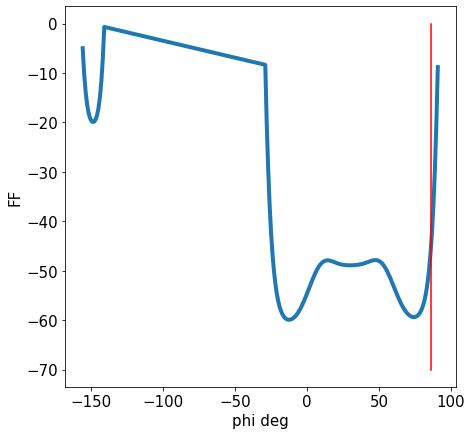

In [222]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['font.size']=15
df_plot = df_FF[df_FF['FF']<0].reset_index()
plt.plot(df_plot['phi1'],df_plot['FF'],lw=4)
plt.plot([86,86],[-70,0],c='red')
plt.xlabel('phi deg')
plt.ylabel('FF')

再現した。ねじれ考慮バージョンに変更したことによるコードのミスはなし。

In [27]:
## 本番フロー ##
monomer_path ='/home/koyama/Working/interaction/mono-C4-BTBT/FF/monomer.csv'
in_csv_path = '/home/koyama/Working/interaction/BTBT/vdw/vdw_step2B_glide=a_edge=a_0.1deg.csv'
out_csv_path = '/home/koyama/Working/interaction/mono-C4-BTBT/vdw/vdw_step2B_glide=a_edge=a_0.1deg.csv'
glide = 'a'
A1_list = np.arange(1,21)
A2_list = np.arange(-90,91)

phi_list = np.arange(50,151)

phi2 = -phi1